In [1]:
#Colab setting
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/DSAIL')

import os
os.chdir('/content/drive/My Drive/DSAIL')

Mounted at /content/drive


In [3]:
# Data U1.base로 train, u1.test로 test data만들기
# U.data는 현재 (["user_id", "movie_id", "rating", "timestamp"])로 구성
import pandas as pd
import numpy as np

file_path = "ml-100k/u1.base"
columns = ["user_id", "movie_id", "rating", "timestamp"]
train_data = pd.read_csv(file_path, sep='\t', names=columns)
user_movie_matrix = train_data.pivot(index='user_id', columns='movie_id', values='rating')
train = user_movie_matrix.fillna(0).to_numpy(dtype=np.float32)

file_path = "ml-100k/u1.test"
columns = ["user_id", "movie_id", "rating", "timestamp"]
test_data = pd.read_csv(file_path, sep='\t', names=columns)
user_movie_matrix = test_data.pivot(index='user_id', columns='movie_id', values='rating')
test = user_movie_matrix.fillna(0).to_numpy(dtype=np.float32)


# # GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print("device", device)


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class OCCF():
  def __init__(self, train_R, test_R, d=50, learning_rate=1e-3, epochs= 50, reg = 0.01, type= 'default'):
    '''
    OCCF
    type: default C = 1 + alpha * r
          else: C = 1 + self.alpha * np.log(1 + self.train_R / self.eps)
    '''
    super(OCCF, self).__init__()
    self.num_user, self.num_item = train_R.shape
    self.test_n, self.test_m = test_R.shape

    self.latent_dimension = d

    self.train_R = train_R
    self.train_P = np.array(train_R > 0, dtype=np.float16) # implicit
    self.test_R = test_R
    self.test_P = np.array(test_R > 0, dtype=np.float16) # implicit

    self.lr = learning_rate
    self.epoch = epochs
    self.reg = reg
    self.criterion = nn.MSELoss()
    print("Number of User:", self.num_user)
    print("Number of Movies:", self.num_item)
    print("Shape of train_R:", self.train_R.shape)
    print("Shape of test_R:", self.test_R.shape)

    self.alpha = 40
    self.eps = 3e-4 # 적정값 뭐지,,

    if type == 'default':
      self.C = 1 + self.alpha * self.train_R # (N, M) confidence
    else:
      self.C = 1 + self.alpha * np.log(1 + self.train_R / self.eps)
    self.test_C = 1 + self.alpha * self.test_R
    # initialize X & Y randomly
    self.X = np.random.standard_normal((self.num_user, self.latent_dimension))
    self.Y = np.random.standard_normal((self.num_item, self.latent_dimension))

    #self.YTY
    #self.XTX
  def update_X(self):
    # YTY는 주어진 상태로, 모든 user에 대하여 X 업데이트
    for u in range(self.num_user):
      Cu = np.diag(self.C[u, :]) # Cu
      first = self.YTY + self.Y.T.dot(Cu - np.identity(self.num_item)).dot(self.Y) + self.reg * np.identity(self.latent_dimension) #(f, f) latent_dimension: f
      second = self.Y.T.dot(Cu).dot(self.train_P[u, :].T) # (f, num_item) X (num_item, 1)) => (f, 1) 아ㅓㅣㅏㅓㅏ item이 논문에서는 n num_item으로 수정
      # X = first-1second를 계산하고 싶고 firstX=second 식을 푸는 셈

      self.X[u, :] = np.linalg.solve(first, second) # X

  def update_Y(self):
    # XTX 주어진 상태로, 모든 item에 대하여 Y 업데이트
    for i in range(self.num_item):
      Ci = np.diag(self.C[:, i]) # ci 각 item에 대하여 interaction 있는 user

      first = self.XTX + self.X.T.dot(Ci - np.identity(self.num_user)).dot(self.X) + self.reg * np.identity(self.latent_dimension) #(f, f) latent_dimension: f
      second = self.X.T.dot(Ci).dot(self.train_P[:, i].T) # (f, num_user) X (num_user, 1)) => (f, 1)

      self.Y[i, :] = np.linalg.solve(first, second)


  def loss(self): # X: (num_user, f) Y (num_item, f) => XYT(num_user, num_item) / 논문대로 였으면 (D, N) 이렇게 시작했어야 함,,
    return np.sum(self.C * np.square(self.train_P - self.X.dot(self.Y.T))) + self.reg * (np.linalg.norm(self.X) + np.linalg.norm(self.Y))

  def prediction(self):
    return self.X.dot(self.Y.T)

  def rank(self, train=True):
    predicted_p = self.prediction()
    # 결국 P가 클수록 선호도가 크다고 봄
    # rank 낮은 애를 많이 추천할수록 성능 good -> rank의 값은 작을수록 좋음
    # 빈 rank 행렬
    rank = np.zeros((self.num_user, self.num_item))
    if train:
      for u in range(self.num_user):
        pu = predicted_p[u, :] # user당 item 나열
        pu_rank = np.argsort(-pu) # -p값 작은애부터 큰 순서대로 index -> 결국 p 큰 애들부터 작은 index
        rank[u, :] = pu_rank / self.num_item

      return np.sum(self.train_R * rank) / np.sum(self.train_R)
    else:
      rank = np.zeros((self.test_n, self.test_m))
      predicted =predicted_p[:self.test_n, :self.test_m]
      for u in range(self.test_n):
        pu = predicted[u, :] # user당 item 나열
        pu_rank = np.argsort(-pu) # -p값 작은애부터 큰 순서대로 index -> 결국 p 큰 애들부터 작은 index
        rank[u, :] = pu_rank / self.test_m
      return np.sum(self.test_R * rank) / np.sum(self.test_R)

  def fit(self):
    train_loss_list = []
    test_loss_list = []
    for epoch in range(self.epoch):
      # X, Y 번갈아 가면서 업데이트
      self.YTY = self.Y.T.dot(self.Y)
      self.update_X()
      self.XTX = self.X.T.dot(self.X)
      self.update_Y()
      train_loss = self.loss()

      train_loss_list.append(train_loss)

      train_ranking = self.rank()
      test_ranking = self.rank(train= False)

      if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{self.epoch}], train_loss: {train_loss}')
        print(f'Epoch [{epoch}/{self.epoch}], train_ranking: {train_ranking}, test_ranking: {test_ranking}')
    return train_loss_list, test_loss_list


In [52]:
import matplotlib.pyplot as plt

model = OCCF(train_R = train, test_R = test, d=15, epochs= 40)

# Train the model
train_loss_list, test_loss_list = model.fit()
train_loss_tensor = torch.tensor(train_loss_list, dtype=torch.float32)
plt.plot(train_loss_tensor.cpu().numpy())
test_loss_tensor = torch.tensor(test_loss_list, dtype=torch.float32)
plt.plot(test_loss_tensor.cpu().numpy())

Number of User: 943
Number of Movies: 1650
Shape of train_R: (943, 1650)
Shape of test_R: (459, 1410)
Epoch [0/40], train_loss: 2194190.5110936295
Epoch [0/40], train_ranking: 0.3655309868850193, test_ranking: 0.4184018173069383
Epoch [10/40], train_loss: 364627.46992818575
Epoch [10/40], train_ranking: 0.3559133335995754, test_ranking: 0.3909610220917401
Epoch [20/40], train_loss: 359610.53634769545
Epoch [20/40], train_ranking: 0.3575219187782426, test_ranking: 0.3913836476473633
Epoch [30/40], train_loss: 357369.72650968545
Epoch [30/40], train_ranking: 0.3572640915940192, test_ranking: 0.39437646559033085


KeyboardInterrupt: 

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class OCCF():
  def __init__(self, train_R, test_R, d=50, learning_rate=1e-3, epochs= 50, reg = 0.01, type= 'default'):
    '''
    OCCF
    type: default C = 1 + alpha * r
          else: C = 1 + self.alpha * np.log(1 + self.train_R / self.eps)
    '''
    super(OCCF, self).__init__()
    self.num_user, self.num_item = train_R.shape
    self.test_n, self.test_m = test_R.shape

    self.latent_dimension = d

    self.train_R = train_R
    self.train_P = np.array(train_R > 0, dtype=np.float16) # implicit
    self.test_R = test_R
    self.test_P = np.array(test_R > 0, dtype=np.float16) # implicit

    self.lr = learning_rate
    self.epoch = epochs
    self.reg = reg
    self.criterion = nn.MSELoss()
    print("Number of User:", self.num_user)
    print("Number of Movies:", self.num_item)
    print("Shape of train_R:", self.train_R.shape)
    print("Shape of test_R:", self.test_R.shape)

    self.alpha = 40
    self.eps = 3e-4 # 적정값 뭐지,,

    if type == 'default':
      self.C = 1 + self.alpha * self.train_R # (N, M) confidence
    else:
      self.C = 1 + self.alpha * np.log(1 + self.train_R / self.eps)
    self.test_C = 1 + self.alpha * self.test_R
    # initialize X & Y randomly
    self.X = np.random.standard_normal((self.num_user, self.latent_dimension))
    self.Y = np.random.standard_normal((self.num_item, self.latent_dimension))

    #self.YTY
    #self.XTX
  def update_X(self):
    # YTY는 주어진 상태로, 모든 user에 대하여 X 업데이트
    for u in range(self.num_user):
      Cu = np.diag(self.C[u, :]) # Cu
      first = self.YTY + np.dot(self.Y.T, (Cu - np.identity(self.num_item))).dot(self.Y) + self.reg * np.identity(self.latent_dimension) #(f, f) latent_dimension: f
      second = self.Y.T.dot(Cu).dot(self.train_P[u, :]) # (f, num_item) X (num_item, 1)) => (f, 1) 아ㅓㅣㅏㅓㅏ item이 논문에서는 n num_item으로 수정
      # X = first-1second를 계산하고 싶고 firstX=second 식을 푸는 셈

      self.X[u, :] = np.dot(np.linalg.inv(first), second) # X

  def update_Y(self):
    # XTX 주어진 상태로, 모든 item에 대하여 Y 업데이트
    for i in range(self.num_item):
      Ci = np.diag(self.C[:, i]) # ci 각 item에 대하여 interaction 있는 user

      first = self.XTX + np.dot(self.X.T, (Ci - np.identity(self.num_user))).dot(self.X) + self.reg * np.identity(self.latent_dimension) #(f, f) latent_dimension: f
      second = self.X.T.dot(Ci).dot(self.train_P[:, i]) # (f, num_user) X (num_user, 1)) => (f, 1)

      self.Y[i, :] = np.dot(np.linalg.inv(first), second)


  def loss(self): # X: (num_user, f) Y (num_item, f) => XYT(num_user, num_item) / 논문대로 였으면 (D, N) 이렇게 시작했어야 함,,
    return np.sum(self.C * np.square(self.train_P - self.X.dot(self.Y.T))) + self.reg * (np.linalg.norm(self.X) + np.linalg.norm(self.Y))

  def prediction(self):
    return self.X.dot(self.Y.T)

  def rank(self, train=True):
    predicted_p = self.prediction()
    # 결국 P가 클수록 선호도가 크다고 봄
    # rank 낮은 애를 많이 추천할수록 성능 good -> rank의 값은 작을수록 좋음
    # 빈 rank 행렬
    rank = np.zeros((self.num_user, self.num_item))
    if train:
      for u in range(self.num_user):
        pu = predicted_p[u, :] # user당 item 나열
        pu_rank = np.argsort(-pu) # -p값 작은애부터 큰 순서대로 index -> 결국 p 큰 애들부터 작은 index
        rank[u, :] = pu_rank / self.num_item
      return np.sum(self.train_R * rank) / np.sum(self.train_R)
    else:
      rank = np.zeros((self.test_n, self.test_m))
      predicted =predicted_p[:self.test_n, :self.test_m]
      for u in range(self.test_n):
        pu = predicted[u, :] # user당 item 나열
        pu_rank = np.argsort(-pu) # -p값 작은애부터 큰 순서대로 index -> 결국 p 큰 애들부터 작은 index
        rank[u, :] = pu_rank / self.test_m
      return np.sum(self.test_R * rank) / np.sum(self.test_R)

  def fit(self):
    train_loss_list = []
    test_loss_list = []
    for epoch in range(self.epoch):
      # X, Y 번갈아 가면서 업데이트
      self.YTY = self.Y.T.dot(self.Y)
      self.update_X()
      self.XTX = self.X.T.dot(self.X)
      self.update_Y()
      train_loss = self.loss()

      train_loss_list.append(train_loss)

      train_ranking = self.rank()
      test_ranking = self.rank(train= False)

      print(f'Epoch [{epoch}/{self.epoch}], train_loss: {train_loss}')
      print(f'Epoch [{epoch}/{self.epoch}], train_ranking: {train_ranking}, test_ranking: {test_ranking}')
    return train_loss_list, test_loss_list


Number of User: 943
Number of Movies: 1650
Shape of train_R: (943, 1650)
Shape of test_R: (459, 1410)
Epoch [0/10], train_loss: 1936319.9075989998
Epoch [0/10], train_ranking: 0.36098166754054073, test_ranking: 0.414871593677736
Epoch [1/10], train_loss: 472109.4293878701
Epoch [1/10], train_ranking: 0.3347437616775976, test_ranking: 0.379259887287817
Epoch [2/10], train_loss: 406686.49923386023
Epoch [2/10], train_ranking: 0.3455409816847175, test_ranking: 0.38416709138825095
Epoch [3/10], train_loss: 387439.29965294566
Epoch [3/10], train_ranking: 0.3491342206053048, test_ranking: 0.3856552014905269
Epoch [4/10], train_loss: 377931.4565176968
Epoch [4/10], train_ranking: 0.3526710227245887, test_ranking: 0.38927906444515714
Epoch [5/10], train_loss: 372240.57334813307
Epoch [5/10], train_ranking: 0.35429285342835565, test_ranking: 0.3882209009553277
Epoch [6/10], train_loss: 368650.17698252056
Epoch [6/10], train_ranking: 0.35537163692703816, test_ranking: 0.38663676466252217
Epoch [

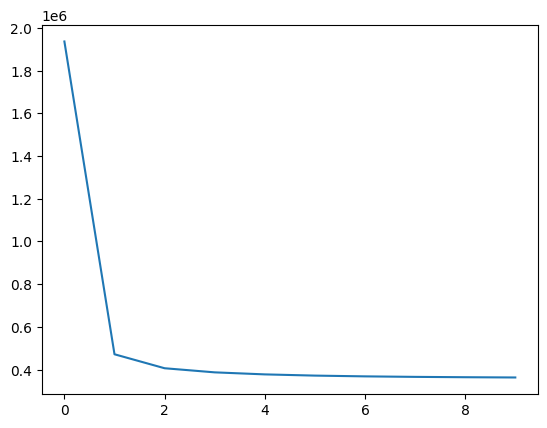

In [54]:
import matplotlib.pyplot as plt

model = OCCF(train_R = train, test_R = test, d=15, epochs= 10)

# Train the model
train_loss_list, test_loss_list = model.fit()
train_loss_tensor = torch.tensor(train_loss_list, dtype=torch.float32)
plt.plot(train_loss_tensor.cpu().numpy())
test_loss_tensor = torch.tensor(test_loss_list, dtype=torch.float32)
plt.plot(test_loss_tensor.cpu().numpy())

np.linalg.solve 이거 쓰는 것보다 np.linalg.inv 쓰는게 훨씬 빠르고, 왜 ranking 개선이 안되는지는 의문.............